<a href="https://www.kaggle.com/code/ifeoluwafaromika/brain-tumor-detection-with-pytorch?scriptVersionId=164030710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
!pip install torchsummary

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shutil import copy, copytree
import cv2, os
from tqdm import tqdm
import math
from torchmetrics import Accuracy
from sklearn.metrics import confusion_matrix


import torch
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional
import PIL
import torchsummary
from torch import nn

import warnings
warnings.filterwarnings('ignore')

In [8]:
from IPython.display import clear_output
clear_output()

In [9]:
ROOT_DIR = '../input/brain-mri-images-for-brain-tumor-detection'

In [10]:
!apt-get install tree
clear_output()
# create new folders
!mkdir data train test val data/yes data/no train/yes train/no test/yes test/no val/yes val/no 
!tree -d

.
|-- data
|   |-- no
|   `-- yes
|-- test
|   |-- no
|   `-- yes
|-- train
|   |-- no
|   `-- yes
`-- val
    |-- no
    `-- yes

12 directories


In [11]:
for category in os.listdir(ROOT_DIR):
    print(category)

no
yes
brain_tumor_dataset


In [12]:
DATA_DIR = '/kaggle/working/data/'

for category in os.listdir(ROOT_DIR):
    if category != 'brain_tumor_dataset':
        for file in os.listdir(f'{ROOT_DIR}/{category}'):
            copy(f'{ROOT_DIR}/{category}/{file}', os.path.join(f'{DATA_DIR}/{category}', file))

In [13]:
len(os.listdir(f'{ROOT_DIR}/no'))

98

In [14]:
len(os.listdir(f'{DATA_DIR}/yes'))

155

In [15]:
# Renaming file in the data directory

for category in os.listdir(DATA_DIR):
    for n, file in enumerate(os.listdir(f'{DATA_DIR}/{category}')):
        file_path = f'{DATA_DIR}/{category}/{file}'
        new_file_path = f'{DATA_DIR}/{category}/{n:03d}.jpg'  
#         print(file_path, new_file_path)
        os.rename(file_path, new_file_path)

## Visualizing to get identifying features

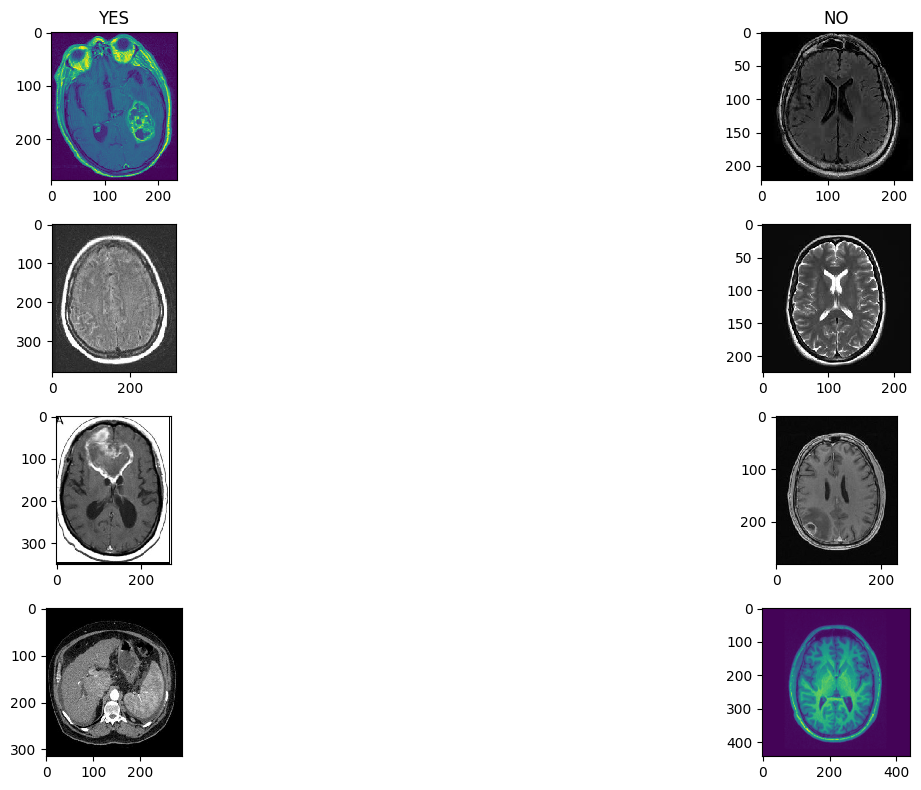

In [16]:
fig, axes = plt.subplots(4,2, figsize=(20, 8))

img1 = plt.imread(f'{DATA_DIR}/yes/092.jpg')
img2 = plt.imread(f'{DATA_DIR}/no/092.jpg')

img3 = plt.imread(f'{DATA_DIR}/yes/086.jpg')
img4 = plt.imread(f'{DATA_DIR}/no/086.jpg')

img5 = plt.imread(f'{DATA_DIR}/yes/042.jpg')
img6 = plt.imread(f'{DATA_DIR}/no/042.jpg')

img7 = plt.imread(f'{DATA_DIR}/yes/014.jpg')
img8 = plt.imread(f'{DATA_DIR}/no/014.jpg')

axes[0,0].imshow(img1, interpolation='nearest')
axes[0,1].imshow(img2, interpolation='nearest')
axes[0,0].set_title('YES')
axes[0,1].set_title('NO')

axes[1,0].imshow(img3, interpolation='nearest')
axes[1,1].imshow(img4, interpolation='nearest')

axes[2,0].imshow(img5, interpolation='nearest')
axes[2,1].imshow(img6, interpolation='nearest')

axes[3,0].imshow(img7, interpolation='nearest')
axes[3,1].imshow(img8, interpolation='nearest')

plt.tight_layout()
plt.show()

In [17]:
# Moving files into train, test and val folders

for category in os.listdir(DATA_DIR):
    for n, file in enumerate(os.listdir(DATA_DIR + f'/{category}')):
        file_path = f'{DATA_DIR}/{category}/{file}'
        
        if n < 5:
            copy(file_path, f'test/{category}/{file}')
        elif n < 0.8 * len(os.listdir(DATA_DIR + f'/{category}')):
            copy(file_path, f'train/{category}/{file}')
        else:
            copy(file_path, f'val/{category}/{file}')

In [18]:
train_transforms = transforms.Compose(
    [
#         transforms.RandomRotation(45),
#         transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
    ]
)

In [19]:
TRAIN_DIR = '/kaggle/working/train/'
TRAIN_DATASET = ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [20]:
sample_img_path = '../input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg'
image = PIL.Image.open(sample_img_path)

num_channels = functional.get_image_num_channels(image)

print('Number of channels: ', num_channels)

Number of channels:  3


In [21]:
count = 0

for file in os.listdir('/kaggle/working/val/yes'):
    sample_img_path = f'/kaggle/working/val/yes/{file}'
    image = PIL.Image.open(sample_img_path)

    num_channels = functional.get_image_num_channels(image)

#     print('Number of channels: ', num_channels)
    if num_channels > 1:
        count+=1
        
print(f"{count} images have 3 channels in the 'yes' category")

28 images have 3 channels in the 'yes' category


In [22]:
print(f"Image size: {image.size}")

Image size: (248, 338)


In [23]:
class TumorClassifier(nn.Module):
    def __init__(self):
        super(TumorClassifier, self).__init__()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)
        
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 * 56, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout(self.pool1(self.relu(self.conv1(x))))
        x = self.dropout(self.pool2(self.relu(self.conv2(x))))
#         x = self.pool3(self.relu(self.conv3(x)))
#         x = self.pool4(self.relu(self.conv4(x)))
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = x.squeeze(0)
        return x

In [24]:
torchsummary.summary(TumorClassifier(), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
           Dropout-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
              ReLU-6         [-1, 32, 112, 112]               0
         MaxPool2d-7           [-1, 32, 56, 56]               0
           Dropout-8           [-1, 32, 56, 56]               0
           Flatten-9               [-1, 100352]               0
           Linear-10                    [-1, 1]         100,353
          Sigmoid-11                    [-1, 1]               0
Total params: 105,153
Trainable params: 105,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

In [25]:
# Converting the Image data to dataloader form

dataloader_train = DataLoader(
    TRAIN_DATASET,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image[0].squeeze().shape)

torch.Size([224, 224])


In [26]:
image, label = next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 1, 224, 224])


## Training

In [27]:
net = TumorClassifier()

optimizer = torch.optim.SGD(net.parameters(), lr=0.02)

criterion = nn.MSELoss()

In [28]:
torch.manual_seed(123)

In [29]:
EPOCH = 30

net.train()
for i in range(EPOCH):
    epoch_loss = 0
    for data, label in tqdm(dataloader_train, total=len(dataloader_train)):
        
        # clearing all gradients
        optimizer.zero_grad()

        # getting outputs from data
        output = net(data)

        # getting the loss
        loss = criterion(output, label.float())

        # aggregating loss over an epoch
        epoch_loss += loss.item()
        
        # back propagation
        loss.backward()

        # gradient and weight updates
        optimizer.step()
    
    print(f"EPOCH: {i+1}/{EPOCH} -> Loss: {epoch_loss}")

100%|██████████| 193/193 [00:03<00:00, 55.09it/s]


EPOCH: 1/30 -> Loss: 42.150146403335384


100%|██████████| 193/193 [00:03<00:00, 53.61it/s]


EPOCH: 2/30 -> Loss: 28.806818958795876


100%|██████████| 193/193 [00:03<00:00, 54.79it/s]


EPOCH: 3/30 -> Loss: 25.26873475846719


100%|██████████| 193/193 [00:03<00:00, 54.81it/s]


EPOCH: 4/30 -> Loss: 21.21017437057924


100%|██████████| 193/193 [00:03<00:00, 53.94it/s]


EPOCH: 5/30 -> Loss: 17.201286879888414


100%|██████████| 193/193 [00:03<00:00, 56.00it/s]


EPOCH: 6/30 -> Loss: 15.584693581891884


100%|██████████| 193/193 [00:03<00:00, 57.80it/s]


EPOCH: 7/30 -> Loss: 13.314085781328274


100%|██████████| 193/193 [00:03<00:00, 62.36it/s]


EPOCH: 8/30 -> Loss: 9.194728738949369


100%|██████████| 193/193 [00:03<00:00, 63.52it/s]


EPOCH: 9/30 -> Loss: 7.5852819342570115


100%|██████████| 193/193 [00:03<00:00, 61.04it/s]


EPOCH: 10/30 -> Loss: 7.237456659915012


100%|██████████| 193/193 [00:03<00:00, 59.80it/s]


EPOCH: 11/30 -> Loss: 4.8096798544568635


100%|██████████| 193/193 [00:03<00:00, 60.52it/s]


EPOCH: 12/30 -> Loss: 3.4905768963731116


100%|██████████| 193/193 [00:03<00:00, 61.62it/s]


EPOCH: 13/30 -> Loss: 1.728569413224485


100%|██████████| 193/193 [00:03<00:00, 61.90it/s]


EPOCH: 14/30 -> Loss: 1.2624655393171076


100%|██████████| 193/193 [00:03<00:00, 62.22it/s]


EPOCH: 15/30 -> Loss: 1.3255987650041634


100%|██████████| 193/193 [00:03<00:00, 61.69it/s]


EPOCH: 16/30 -> Loss: 1.212294164022954


100%|██████████| 193/193 [00:03<00:00, 58.55it/s]


EPOCH: 17/30 -> Loss: 1.2442304749441269


100%|██████████| 193/193 [00:03<00:00, 61.56it/s]


EPOCH: 18/30 -> Loss: 1.0955807522416146


100%|██████████| 193/193 [00:03<00:00, 62.23it/s]


EPOCH: 19/30 -> Loss: 1.090119819044413


100%|██████████| 193/193 [00:03<00:00, 62.11it/s]


EPOCH: 20/30 -> Loss: 1.109795870250321


100%|██████████| 193/193 [00:03<00:00, 61.82it/s]


EPOCH: 21/30 -> Loss: 1.0730536229055574


100%|██████████| 193/193 [00:03<00:00, 61.25it/s]


EPOCH: 22/30 -> Loss: 1.0592600313393923


100%|██████████| 193/193 [00:03<00:00, 62.22it/s]


EPOCH: 23/30 -> Loss: 1.0552310790802235


100%|██████████| 193/193 [00:03<00:00, 61.23it/s]


EPOCH: 24/30 -> Loss: 1.0596582736591142


100%|██████████| 193/193 [00:03<00:00, 62.40it/s]


EPOCH: 25/30 -> Loss: 1.048871678961296


100%|██████████| 193/193 [00:03<00:00, 62.17it/s]


EPOCH: 26/30 -> Loss: 1.040237928976788


100%|██████████| 193/193 [00:03<00:00, 58.45it/s]


EPOCH: 27/30 -> Loss: 1.0515467734273527


100%|██████████| 193/193 [00:03<00:00, 61.65it/s]


EPOCH: 28/30 -> Loss: 1.0463252350791297


100%|██████████| 193/193 [00:03<00:00, 62.08it/s]


EPOCH: 29/30 -> Loss: 1.031745511457201


100%|██████████| 193/193 [00:03<00:00, 61.88it/s]

EPOCH: 30/30 -> Loss: 1.0356240475093579


## Validation

In [33]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(),
])

VAL_DIR = '/kaggle/working/val/'
VAL_DATASET = ImageFolder(root=VAL_DIR, transform=test_transforms)

dataloader_val = DataLoader(
    VAL_DATASET,
    batch_size=1,
)

In [34]:
net.eval()

metric = Accuracy(task='binary')

labels = []
predictions = []

with torch.no_grad():
    for data, label in dataloader_val:
        output = net.forward(data)
        prediction = round(output.numpy().flatten()[0])
#         print(f"Ground Truth Label: {label[0]}, Prediction: {prediction}")
        metric(output, label)
        labels.append(label)
        predictions.append(prediction)
    acc = metric.compute()
    
    print(f"Validation Accuracy: {acc*100:.2f}%")

Validation Accuracy: 84.00%


<Axes: >

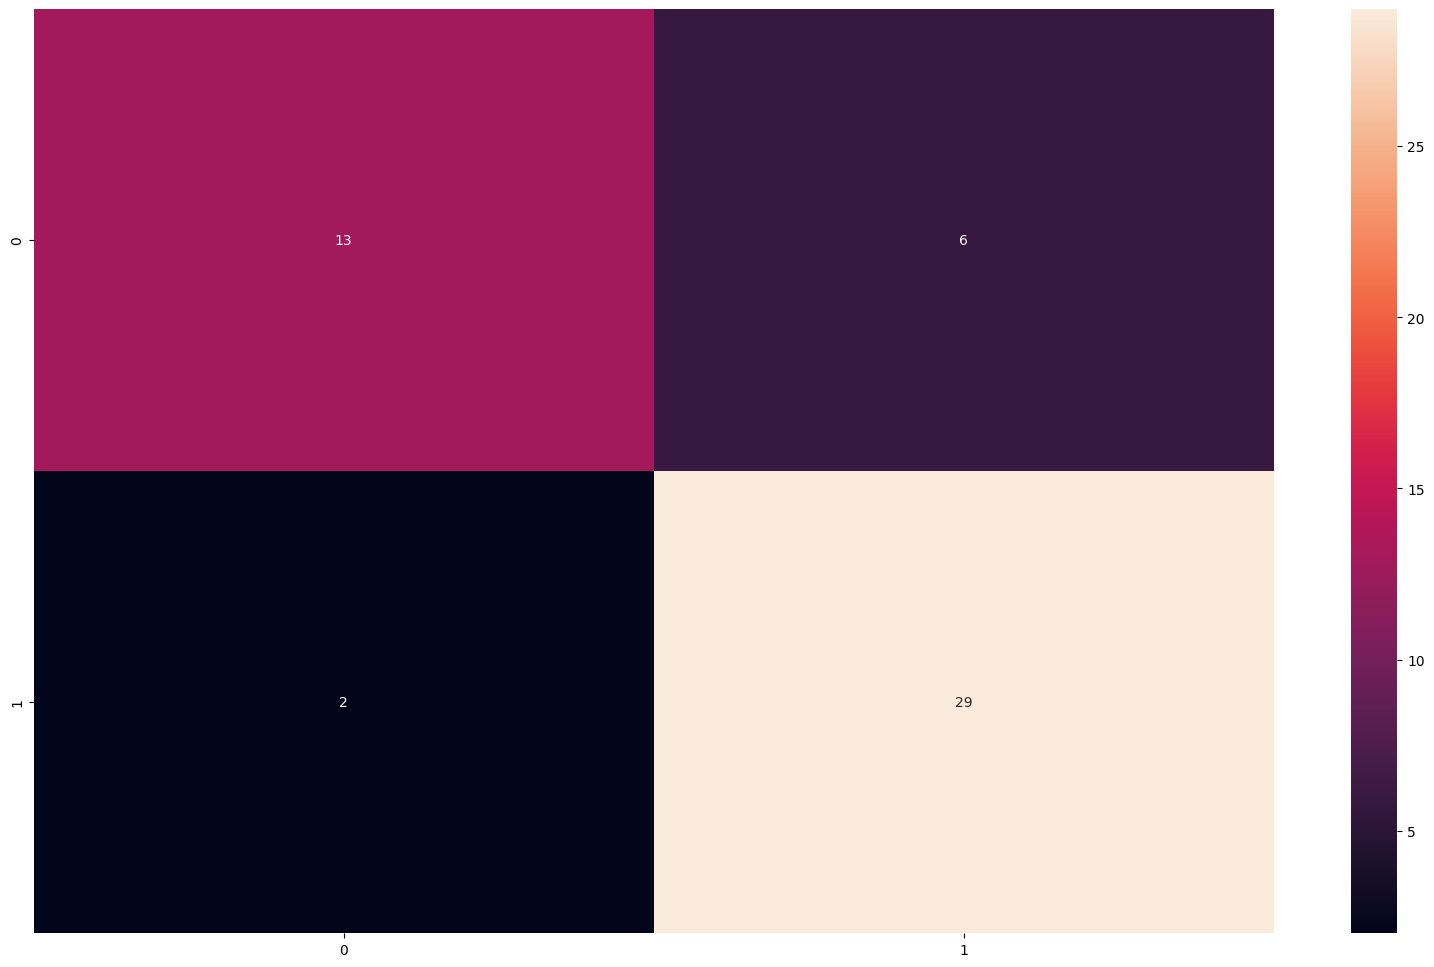

In [36]:
plt.figure(figsize=(20, 12))
sns.heatmap(confusion_matrix(labels, predictions), annot=True)

In [37]:
metric = Accuracy(task='binary')

with torch.no_grad():
    for data, label in dataloader_train:
        output = net.forward(data)
        prediction = round(output.numpy().flatten()[0])
#         print(f"Ground Truth Label: {label[0]}, Prediction: {prediction}")
        metric(output, label)
    acc = metric.compute()
    
    print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 99.48%


In [38]:
torch.save(net.state_dict(), 'weights.pth')

In [39]:
net = TumorClassifier()
net.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

In [40]:
### test dataloader
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(),
])

TEST_DIR = '/kaggle/working/test/'
TEST_DATASET = ImageFolder(root=TEST_DIR, transform=test_transforms)

dataloader_test = DataLoader(
    TEST_DATASET,
    batch_size=1,
)

In [41]:
test_metric = Accuracy(task='binary')

net.eval()

with torch.no_grad():
    for data, label in dataloader_test:
        output = net.forward(data)
        prediction = round(output.numpy().flatten()[0])
        print(f"Ground Truth Label: {label[0]}, Prediction: {prediction}")
        test_metric(output, label)
        
    test_acc = test_metric.compute()
    print(f"Test Accuracy: {test_acc*100:.2f}%")

Ground Truth Label: 0, Prediction: 1
Ground Truth Label: 0, Prediction: 1
Ground Truth Label: 0, Prediction: 0
Ground Truth Label: 0, Prediction: 1
Ground Truth Label: 0, Prediction: 0
Ground Truth Label: 1, Prediction: 1
Ground Truth Label: 1, Prediction: 0
Ground Truth Label: 1, Prediction: 1
Ground Truth Label: 1, Prediction: 1
Ground Truth Label: 1, Prediction: 1
Test Accuracy: 60.00%
